In [2]:
import numpy as np
import os

#### Read

def load_flatpack(k_index, flat_dir="lambda_flat_triplet"):
    path = os.path.join(flat_dir, f"flat_k{k_index:05d}.npz")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Not found: {path}")
    z = np.load(path, allow_pickle=True)
    return {
        "L0flat": z["L0flat"],          # (3,2,2)
        "L1flat": z["L1flat"],          # (3,2,2)
        "Eplus_flat":  z["Eplus_flat"], # (2,)
        "Eminus_flat": z["Eminus_flat"],# (2,)
        "flat_plus_idx":  z["flat_plus_idx"],   # (2,)
        "flat_minus_idx": z["flat_minus_idx"],  # (2,)
        "k": z["k"], "k_index": int(z["k_index"])
    }

def flat_bdg_from_flatpack(pack, *,DeltaLayer0, DeltaLayer1,mu):
    #
    Δ0 = np.asarray(DeltaLayer0, complex).ravel()
    Δ1 = np.asarray(DeltaLayer1, complex).ravel()
    if Δ0.size != 3 or Δ1.size != 3:
        raise ValueError("DeltaLayer0/1 must each have length 3.")
    # 
    
    Fp = np.diag(np.asarray(pack["Eplus_flat"], float))     # (2,2)
    Fm = -np.diag(np.asarray(pack["Eminus_flat"], float))   # (2,2)

    # build 2×2 Gap_flat = V * Σ_s ( Δ0_s Λ0_s^* + Δ1_s Λ1_s^* )
    L0flat = np.asarray(pack["L0flat"])
    L1flat = np.asarray(pack["L1flat"])
    #
    Gap_flat = sum(Δ0[s] * np.conj(L0flat[s]) + Δ1[s] * np.conj(L1flat[s]) for s in (0,))
    ### Only read s=0 channel now.
    I = np.eye(Fp.shape[0], dtype=complex)
    HLL = np.block([
        [Fp-mu*I,            Gap_flat        ],
        [Gap_flat.conj().T,   Fm+mu*I        ]
    ]).astype(complex)
    return HLL, Gap_flat

 

In [76]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri



def _scan_flat_indices(folder: str):
    """Find flat_kXXXXX.npz files; return sorted list of integer indices."""
    if not os.path.isdir(folder):
        raise FileNotFoundError(f"Directory not found: {folder}")
    pat = re.compile(r"flat_k(\d{5})\.npz$")
    idxs = []
    for name in os.listdir(folder):
        m = pat.match(name)
        if m:
            idxs.append(int(m.group(1)))
    if not idxs:
        raise FileNotFoundError(f"No files matching flat_kXXXXX.npz in {folder}")
    return sorted(idxs)

def collect_bdg_eigs(flat_dir, DeltaLayer0, DeltaLayer1,mu):
    """
    For every flat_kXXXXX.npz in flat_dir:
      - load pack (your load_flatpack),
      - build HLL (your flat_bdg_from_flatpack),
      - eigendecompose (4 eigenvalues).
    Returns: kx (N,), ky (N,), k_index (N,), evals (N,4)
    """
    idxs = _scan_flat_indices(flat_dir)
    kx, ky, k_index, evals = [], [], [], []

    for idx in idxs:
        pack = load_flatpack(idx, flat_dir=flat_dir)  # <-- your function
        HLL, _ = flat_bdg_from_flatpack(              # <-- your function (uses s=0 channel)
            pack, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1,mu=mu
        )
        vals, _ = np.linalg.eigh(HLL)                 # (4,)
        kvec = np.asarray(pack["k"], float).reshape(2,)
        kx.append(kvec[0]); ky.append(kvec[1]); k_index.append(idx)
        evals.append(np.real_if_close(vals))

    return np.array(kx), np.array(ky), np.array(k_index, int), np.vstack(evals)

def plot_eigs_vs_kindex(k_index, evals, *, title, save_png=False, outdir="plots_bdg_eigs"):
    plt.figure()
    for col in range(evals.shape[1]):
        plt.plot(k_index, evals[:, col], label=f"eig {col}",marker="o",linewidth=0,markersize=1)
    plt.xlabel("k_index (path order)")
    plt.ylabel("Eigenvalue")
    plt.title(title)
    #plt.legend()
    #plt.ylim([-0.0001,0.0001])
    if save_png:
        os.makedirs(outdir, exist_ok=True)
        plt.savefig(os.path.join(outdir, "eig_vs_kindex.png"), dpi=150, bbox_inches="tight")
    plt.show()

def plot_eigs_on_mesh(kx, ky, evals, *, base_title, save_png=False, outdir="plots_bdg_eigs"):
    tri = mtri.Triangulation(kx, ky)
    for col in [2]:
        plt.figure(figsize=(6,5))
        im = plt.tripcolor(tri, evals[:, col], shading="gouraud")  # smooth coloring
        plt.scatter(kx, ky, s=6, c="k", alpha=0.25)                 # optional markers
        plt.gca().set_aspect("equal", adjustable="box")
        plt.colorbar(im, label="eigenvalue")
        plt.xlabel(r"$k_x$")
        plt.ylabel(r"$k_y$")
        plt.title(f"{base_title} — eigenvalue {col}")
        plt.tight_layout()
        if save_png:
            os.makedirs(outdir, exist_ok=True)
            plt.savefig(os.path.join(outdir, f"eig_{col}_kmap.png"), dpi=200, bbox_inches="tight")
        plt.show()

 

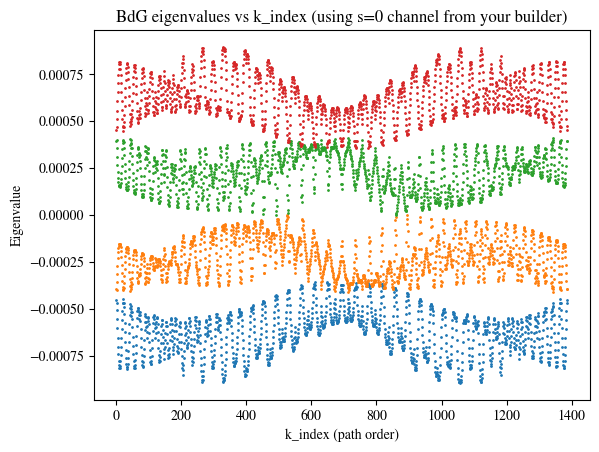

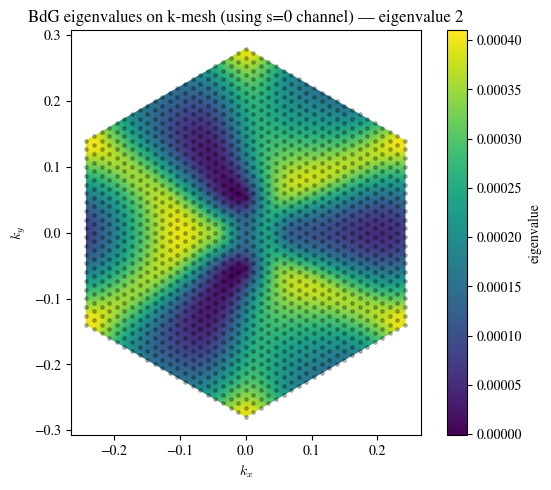

In [77]:
flat_dir     = "lambda_flat_singlet"   # folder with flat_kXXXXX.npz
Δ0=+1.187420e-03+2.675820e-06j;
Δ1=-1.187327e-03+2.738146e-06j;
mu=+1.122022e-03; 
DeltaLayer0  = (Δ0, 0.0, 0.0)         # length-3, your function will read s=0
DeltaLayer1  = (Δ1, 0.0, 0.0)
save_png     = False                   # set True to save figures
plots_outdir = "plots_bdg_eigs"
# 
        
        
        
# ----- run -----
kx, ky, k_index, evals = collect_bdg_eigs(flat_dir, DeltaLayer0, DeltaLayer1,mu=mu)

plot_eigs_vs_kindex(
    k_index, evals,
    title="BdG eigenvalues vs k_index (using s=0 channel from your builder)",
    save_png=save_png, outdir=plots_outdir
)

plot_eigs_on_mesh(
    kx, ky, evals,
    base_title="BdG eigenvalues on k-mesh (using s=0 channel)",
   save_png=save_png, outdir=plots_outdir
)

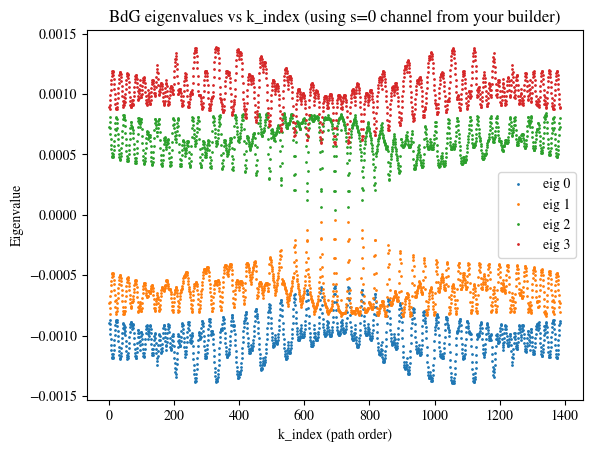

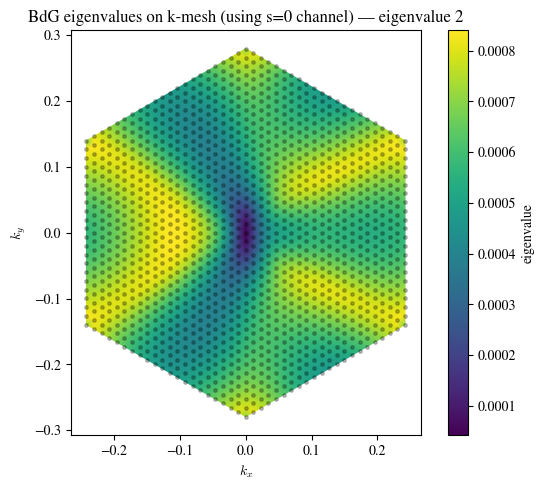

In [75]:
flat_dir     = "lambda_flat_singlet"   # folder with flat_kXXXXX.npz
#Δ0=+2.532643e-03+6.358490e-06j; Δ1=-2.532462e-03+6.349393e-06j;
#mu=9.369006e-04; 
Δ0=+2.773524e-03+6.992516e-06j;
Δ1=-2.773324e-03+7.009747e-06j;
mu=+8.989287e-04

DeltaLayer0  = (Δ0, 0.0, 0.0)         # length-3, your function will read s=0
DeltaLayer1  = (Δ1, 0.0, 0.0)
save_png     = False                   # set True to save figures
plots_outdir = "plots_bdg_eigs"
# 
        
        
        
# ----- run -----
kx, ky, k_index, evals = collect_bdg_eigs(flat_dir, DeltaLayer0, DeltaLayer1,mu=mu)

plot_eigs_vs_kindex(
    k_index, evals,
    title="BdG eigenvalues vs k_index (using s=0 channel from your builder)",
    save_png=save_png, outdir=plots_outdir
)

plot_eigs_on_mesh(
    kx, ky, evals,
    base_title="BdG eigenvalues on k-mesh (using s=0 channel)",
   save_png=save_png, outdir=plots_outdir
)

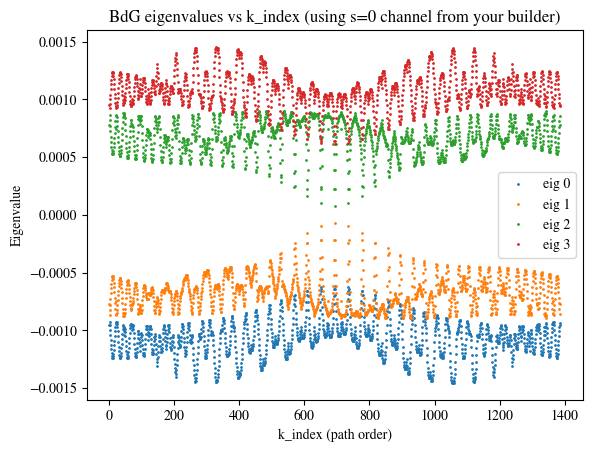

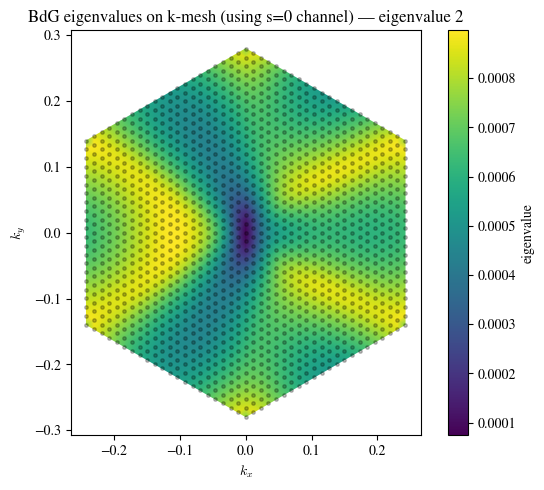

In [72]:
 
flat_dir     = "lambda_flat_singlet"   # folder with flat_kXXXXX.npz
Δ0=+2.963989e-03+7.460098e-06j;
Δ1=-2.963774e-03+7.472360e-06j;
mu=+8.682626e-04;

DeltaLayer0  = (Δ0, 0.0, 0.0)         # length-3, your function will read s=0
DeltaLayer1  = (Δ1, 0.0, 0.0)
save_png     = False                   # set True to save figures
plots_outdir = "plots_bdg_eigs"
# 
        
        
        
# ----- run -----
kx, ky, k_index, evals = collect_bdg_eigs(flat_dir, DeltaLayer0, DeltaLayer1,mu=mu)

plot_eigs_vs_kindex(
    k_index, evals,
    title="BdG eigenvalues vs k_index (using s=0 channel from your builder)",
    save_png=save_png, outdir=plots_outdir
)

plot_eigs_on_mesh(
    kx, ky, evals,
    base_title="BdG eigenvalues on k-mesh (using s=0 channel)",
   save_png=save_png, outdir=plots_outdir
)

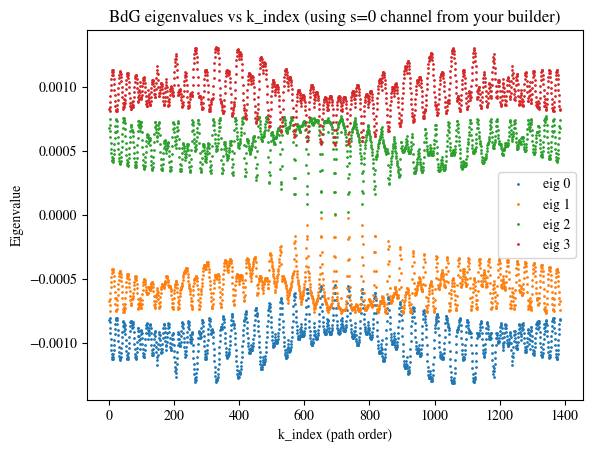

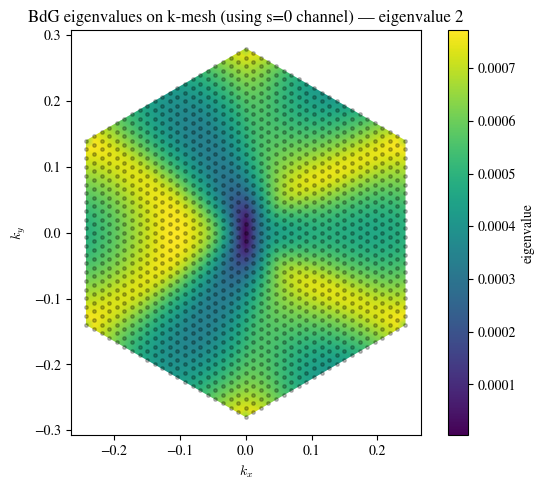

In [74]:
flat_dir     = "lambda_flat_singlet"   # folder with flat_kXXXXX.npz
Δ0=+2.532643e-03+6.358490e-06j; Δ1=-2.532462e-03+6.349393e-06j;
mu=9.369006e-04; 

DeltaLayer0  = (Δ0, 0.0, 0.0)         # length-3, your function will read s=0
DeltaLayer1  = (Δ1, 0.0, 0.0)
save_png     = False                   # set True to save figures
plots_outdir = "plots_bdg_eigs"
# 
        
        
        
# ----- run -----
kx, ky, k_index, evals = collect_bdg_eigs(flat_dir, DeltaLayer0, DeltaLayer1,mu=mu)

plot_eigs_vs_kindex(
    k_index, evals,
    title="BdG eigenvalues vs k_index (using s=0 channel from your builder)",
    save_png=save_png, outdir=plots_outdir
)

plot_eigs_on_mesh(
    kx, ky, evals,
    base_title="BdG eigenvalues on k-mesh (using s=0 channel)",
   save_png=save_png, outdir=plots_outdir
)

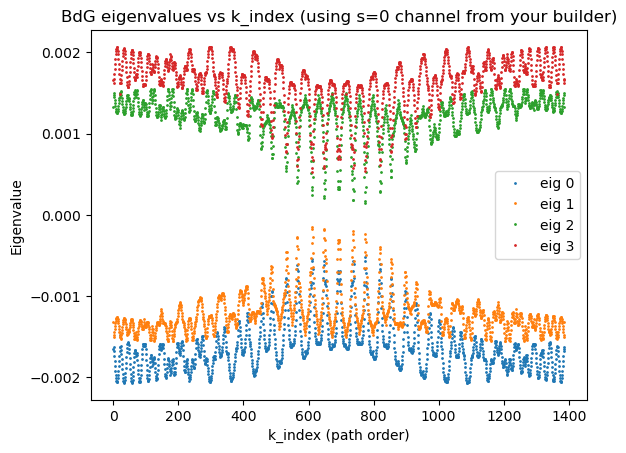

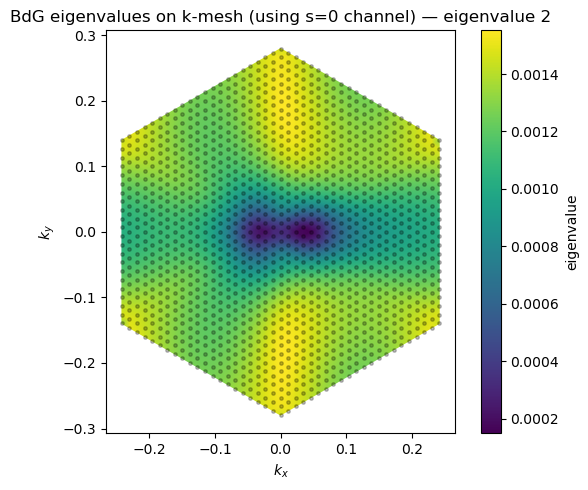

In [35]:
flat_dir     = "lambda_flat_singlet"   # folder with flat_kXXXXX.npz

Δ0=+2.532643e-03+6.358490e-06j; 
Δ1=-2.532462e-03+6.349393e-06j;
mu=9.369006e-04; 

DeltaLayer0  = (Δ0, 0.0, 0.0)         # length-3, your function will read s=0
DeltaLayer1  = (Δ0, 0.0, 0.0)
save_png     = False                   # set True to save figures
plots_outdir = "plots_bdg_eigs"
# 
        
        
        
# ----- run -----
kx, ky, k_index, evals = collect_bdg_eigs(flat_dir, DeltaLayer0, DeltaLayer1,mu=mu)

plot_eigs_vs_kindex(
    k_index, evals,
    title="BdG eigenvalues vs k_index (using s=0 channel from your builder)",
    save_png=save_png, outdir=plots_outdir
)

plot_eigs_on_mesh(
    kx, ky, evals,
    base_title="BdG eigenvalues on k-mesh (using s=0 channel)",
   save_png=save_png, outdir=plots_outdir
)


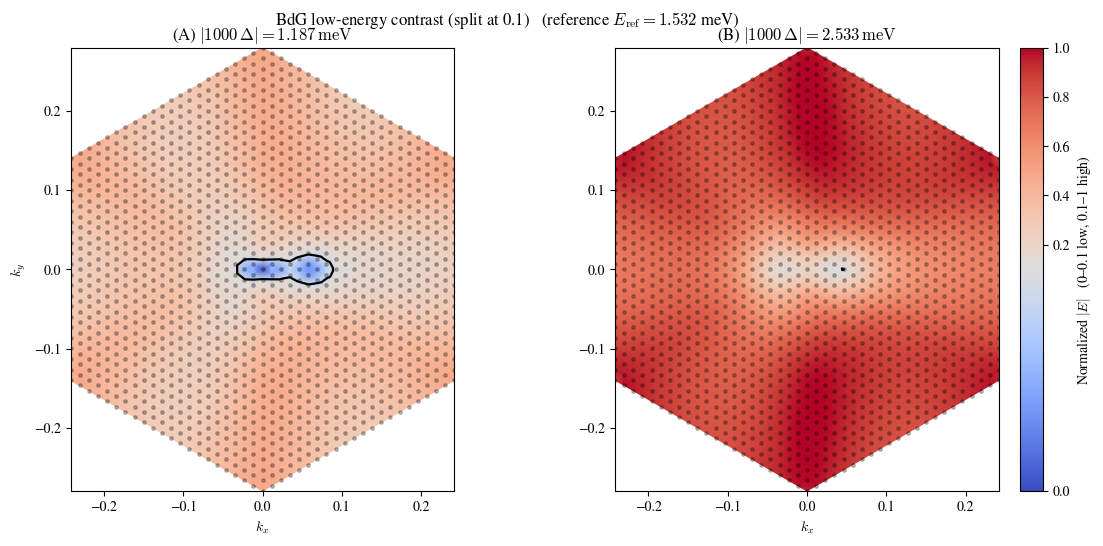

In [52]:
import os, numpy as np, matplotlib.pyplot as plt, matplotlib.tri as mtri
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap, BoundaryNorm

def _segmented_cmap_01():
    # 0–0.1: blue ramp; 0.1–1: yellow→red ramp
    cdict = {
        "red":   [(0.00, 0.05, 0.05), (0.10, 0.30, 0.95), (1.00, 0.95, 0.95)],
        "green": [(0.00, 0.10, 0.10), (0.10, 0.85, 0.85), (1.00, 0.10, 0.10)],
        "blue":  [(0.00, 0.40, 0.40), (0.10, 0.20, 0.00), (1.00, 0.00, 0.00)],
    }
    return LinearSegmentedColormap("low_high_split_01", cdict)

def plot_absE_norm_split_01(
    kxA, kyA, evalsA, ΔA,
    kxB, kyB, evalsB, ΔB,
    *, col=2, meV=True, percentile_ref=99,
    mode="diverging",                        # "diverging" or "segmented"
    base_title="BdG |E| normalized (0–1), split at 0.1",
    save_png=False, outdir="plots_bdg_eigs", fname="absE_split_01.png"
):
    triA = mtri.Triangulation(kxA, kyA)
    triB = mtri.Triangulation(kxB, kyB)

    # branch → meV
    scale = 1000.0 if meV else 1.0
    EA = scale * np.asarray(evalsA[:, col], float)
    EB = scale * np.asarray(evalsB[:, col], float)

    # shared robust reference, normalize to [0,1]
    A, B = np.abs(EA), np.abs(EB)
    E_ref = np.nanpercentile(np.r_[A, B], percentile_ref)
    NA = np.clip(A / E_ref, 0.0, 1.0)
    NB = np.clip(B / E_ref, 0.0, 1.0)

    # color model
    if mode == "diverging":
        # smooth diverging map centered at 0.1
        norm = TwoSlopeNorm(vmin=0.0, vcenter=0.1, vmax=1.0)
        cmap = "coolwarm"   # try "BrBG", "PiYG", "seismic" if you prefer
        cbar_kw = {}
    elif mode == "segmented":
        # two-band segmented map split at 0.1 (categorical feel)
        cmap = _segmented_cmap_01()
        bounds = np.r_[np.linspace(0, 0.1, 6), np.linspace(0.15, 1.0, 18)]
        norm = BoundaryNorm(bounds, ncolors=256, clip=True)
        cbar_kw = dict(ticks=[0, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0])
    else:
        raise ValueError("mode must be 'diverging' or 'segmented'")

    # plot
    fig, axes = plt.subplots(1, 2, figsize=(11.8, 5.2), constrained_layout=True)
    for ax, tri, N, Δ, tag in [(axes[0], triA, NA, ΔA, "A"), (axes[1], triB, NB, ΔB, "B")]:
        im = ax.tripcolor(tri, N, shading="gouraud", cmap=cmap, norm=norm)
        ax.scatter(tri.x, tri.y, s=6, c="k", alpha=0.25)
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel(r"$k_x$")
        if ax is axes[0]: ax.set_ylabel(r"$k_y$")
        ax.set_title(fr"({tag}) $|1000\,\Delta| = {abs(Δ)*1000:.3f}\,\mathrm{{meV}}$")
        ax.tricontour(tri, N, levels=[0.1], colors="k", linewidths=1.6)  # bold 0.1

    cbar = fig.colorbar(im, ax=axes, location="right", fraction=0.05, pad=0.02, **cbar_kw)
    cbar.set_label(r"Normalized $|E|$   (0–0.1 low, 0.1–1 high)")

    fig.suptitle(base_title + fr"   (reference $E_\mathrm{{ref}}={E_ref:.3f}$ meV)", y=1.02, fontsize=12)
    if save_png:
        os.makedirs(outdir, exist_ok=True)
        fig.savefig(os.path.join(outdir, fname), dpi=240, bbox_inches="tight")
    plt.show()

# --- Case A ---
Δ0A = +1.187420e-03 + 2.675820e-06j
muA = +1.122022e-03
DeltaLayer0A = (Δ0A, 0.0, 0.0); DeltaLayer1A = (Δ0A, 0.0, 0.0)
kxA, kyA, _, evalsA = collect_bdg_eigs(flat_dir, DeltaLayer0A, DeltaLayer1A, mu=muA)

# --- Case B ---
Δ0B = +2.532643e-03 + 6.358490e-06j
muB = 9.369006e-04
DeltaLayer0B = (Δ0B, 0.0, 0.0); DeltaLayer1B = (Δ0B, 0.0, 0.0)
kxB, kyB, _, evalsB = collect_bdg_eigs(flat_dir, DeltaLayer0B, DeltaLayer1B, mu=muB)

plot_absE_norm_split_01(
    kxA, kyA, evalsA, Δ0A,
    kxB, kyB, evalsB, Δ0B,
    col=2, percentile_ref=99,
    mode="diverging",   # or "segmented" for a categorical split
    base_title="BdG low-energy contrast (split at 0.1)",
    save_png=False
)
    

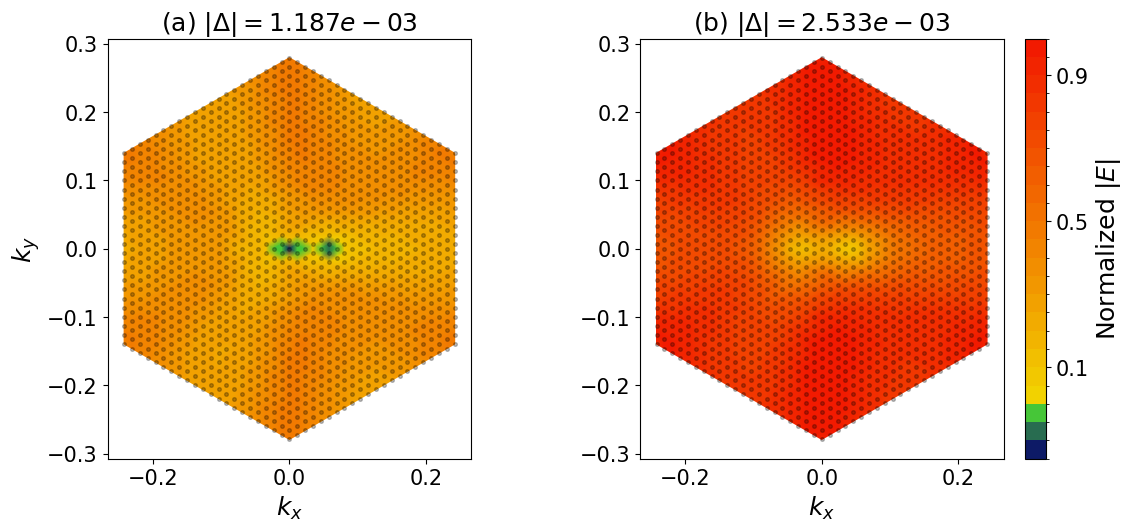

In [47]:
import os, numpy as np, matplotlib.pyplot as plt, matplotlib.tri as mtri
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap, BoundaryNorm

def _segmented_cmap_01():
    # 0–0.1: blue-ish; 0.1–1: yellow→red
    cdict = {
        "red":   [(0.00, 0.05, 0.05), (0.10, 0.30, 0.95), (1.00, 0.95, 0.95)],
        "green": [(0.00, 0.10, 0.10), (0.10, 0.85, 0.85), (1.00, 0.10, 0.10)],
        "blue":  [(0.00, 0.40, 0.40), (0.10, 0.20, 0.00), (1.00, 0.00, 0.00)],
    }
    return LinearSegmentedColormap("low_high_split_01", cdict)

def plot_absE_norm_split_01(
    kxA, kyA, evalsA, ΔA,
    kxB, kyB, evalsB, ΔB,
    *, col=2, meV=True, percentile_ref=99,
    mode="segmented",                        # "segmented" (crisp) or "diverging" (smooth)
    save_png=False, outdir="plots_bdg_eigs", fname="absE_split_01.png",
    label_fs=16, tick_fs=14, scatter_s=7
):
    triA = mtri.Triangulation(kxA, kyA)
    triB = mtri.Triangulation(kxB, kyB)

    # Branch → (optionally) meV
    scale = 1000.0 if meV else 1.0
    EA = scale * np.asarray(evalsA[:, col], float)
    EB = scale * np.asarray(evalsB[:, col], float)

    # Shared robust reference; normalize |E| to [0,1]
    A, B = np.abs(EA), np.abs(EB)
    E_ref = np.nanpercentile(np.r_[A, B], percentile_ref)
    NA = np.clip(A / E_ref, 0.0, 1.0)
    NB = np.clip(B / E_ref, 0.0, 1.0)

    # Color model: split at 0.1
    if mode == "diverging":
        norm = TwoSlopeNorm(vmin=0.0, vcenter=0.1, vmax=1.0)
        cmap = "coolwarm"
        cbar_ticks = [0.1, 0.5, 0.9]
    elif mode == "segmented":
        cmap = _segmented_cmap_01()
        bounds = np.r_[np.linspace(0, 0.1, 6), np.linspace(0.15, 1.0, 18)]
        norm = BoundaryNorm(bounds, ncolors=256, clip=True)
        cbar_ticks = [0.1, 0.5, 0.9]
    else:
        raise ValueError("mode must be 'segmented' or 'diverging'")

    fig, axes = plt.subplots(1, 2, figsize=(11.8, 5.2), constrained_layout=True)

    # --- Panel (a) ---
    imA = axes[0].tripcolor(triA, NA, shading="gouraud", cmap=cmap, norm=norm)
    axes[0].scatter(kxA, kyA, s=scatter_s, c="k", alpha=0.25)
    axes[0].set_aspect("equal", adjustable="box")
    axes[0].set_xlabel(r"$k_x$", fontsize=label_fs)
    axes[0].set_ylabel(r"$k_y$", fontsize=label_fs)
    axes[0].tick_params(axis="both", labelsize=tick_fs)
    axes[0].set_title(fr"(a) $|\Delta|={abs(ΔA):.3e}$", fontsize=label_fs)

    # --- Panel (b) ---
    imB = axes[1].tripcolor(triB, NB, shading="gouraud", cmap=cmap, norm=norm)
    axes[1].scatter(kxB, kyB, s=scatter_s, c="k", alpha=0.25)
    axes[1].set_aspect("equal", adjustable="box")
    axes[1].set_xlabel(r"$k_x$", fontsize=label_fs)
    axes[1].tick_params(axis="both", labelsize=tick_fs)
    axes[1].set_title(fr"(b) $|\Delta|={abs(ΔB):.3e}$", fontsize=label_fs)

    # Shared colorbar (no suptitle)
    cbar = fig.colorbar(imB, ax=axes, location="right", fraction=0.05, pad=0.02)
    cbar.set_label(r"Normalized $|E|$", fontsize=label_fs)
    cbar.set_ticks(cbar_ticks)
    cbar.ax.tick_params(labelsize=tick_fs)

    if save_png:
        os.makedirs(outdir, exist_ok=True)
        fig.savefig(os.path.join(outdir, fname), dpi=240, bbox_inches="tight")
    plt.show()


# --- Case A ---
Δ0A = +1.187420e-03 + 2.675820e-06j
muA = +1.122022e-03
DeltaLayer0A = (Δ0A, 0.0, 0.0); DeltaLayer1A = (Δ0A, 0.0, 0.0)
kxA, kyA, _, evalsA = collect_bdg_eigs(flat_dir, DeltaLayer0A, DeltaLayer1A, mu=muA)

# --- Case B ---
Δ0B = +2.532643e-03 + 6.358490e-06j
muB = 9.369006e-04
DeltaLayer0B = (Δ0B, 0.0, 0.0); DeltaLayer1B = (Δ0B, 0.0, 0.0)
kxB, kyB, _, evalsB = collect_bdg_eigs(flat_dir, DeltaLayer0B, DeltaLayer1B, mu=muB)

plot_absE_norm_split_01(
    kxA, kyA, evalsA, Δ0A,
    kxB, kyB, evalsB, Δ0B,
    col=2, percentile_ref=99,
    mode="segmented",          # or "diverging"
    save_png=False,
    label_fs=18, tick_fs=15    # tweak sizes if you want even bigger
)



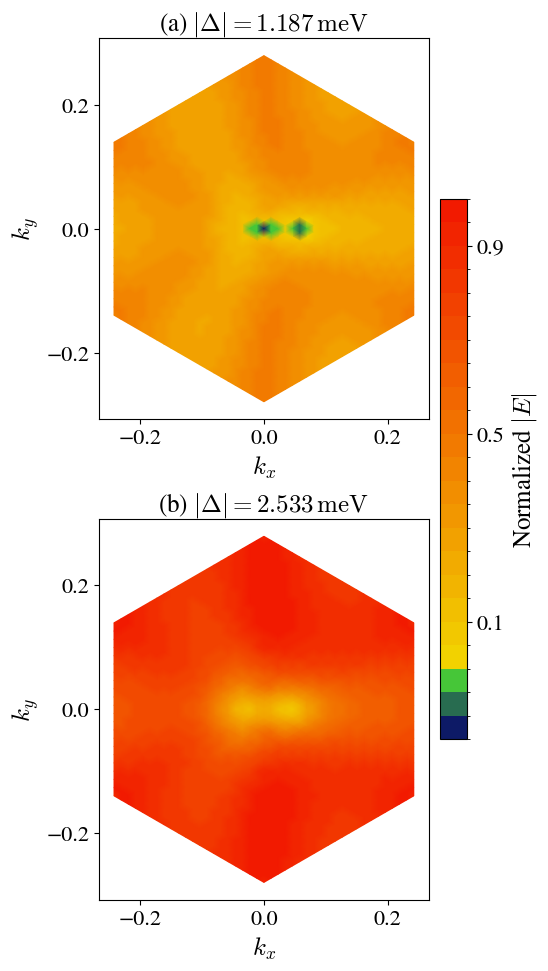

In [48]:

import matplotlib
matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"

import os, numpy as np, matplotlib.pyplot as plt, matplotlib.tri as mtri
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap

def _segmented_cmap_01():
    # Same "previous" palette: 0–0.1 blue-ish; 0.1–1 yellow→red
    cdict = {
        "red":   [(0.00, 0.05, 0.05), (0.10, 0.30, 0.95), (1.00, 0.95, 0.95)],
        "green": [(0.00, 0.10, 0.10), (0.10, 0.85, 0.85), (1.00, 0.10, 0.10)],
        "blue":  [(0.00, 0.40, 0.40), (0.10, 0.20, 0.00), (1.00, 0.00, 0.00)],
    }
    return LinearSegmentedColormap("low_high_split_01", cdict)

def plot_absE_norm_split_01_column(
    kxA, kyA, evalsA, ΔA,
    kxB, kyB, evalsB, ΔB,
    *, col=2, meV=True, percentile_ref=99,
    save_png=False, outdir="plots_bdg_eigs", fname="absE_split_01_col.png",
    label_fs=16, tick_fs=14, yticks=(-0.2, 0.0, 0.2)
):
    triA = mtri.Triangulation(kxA, kyA)
    triB = mtri.Triangulation(kxB, kyB)

    # Branch → (optionally) meV
    scale = 1000.0 if meV else 1.0
    EA = scale * np.asarray(evalsA[:, col], float)
    EB = scale * np.asarray(evalsB[:, col], float)

    # Normalize |E| to [0,1] with robust shared reference
    A, B = np.abs(EA), np.abs(EB)
    E_ref = np.nanpercentile(np.r_[A, B], percentile_ref)
    NA = np.clip(A / E_ref, 0.0, 1.0)
    NB = np.clip(B / E_ref, 0.0, 1.0)

    # Segmented colormap split at 0.1 (same as before)
    cmap = _segmented_cmap_01()
    bounds = np.r_[np.linspace(0, 0.1, 6), np.linspace(0.15, 1.0, 18)]
    norm = BoundaryNorm(bounds, ncolors=256, clip=True)

    # Column layout: 2 rows × 1 column
    fig, axes = plt.subplots(2, 1, figsize=(6.6, 9.6), constrained_layout=True)
    axA, axB = axes

    # Panel (a)
    imA = axA.tripcolor(triA, NA, shading="gouraud", cmap=cmap, norm=norm)
    axA.set_aspect("equal", adjustable="box")
    axA.set_xlabel(r"$k_x$", fontsize=label_fs)
    axA.set_ylabel(r"$k_y$", fontsize=label_fs)
    axA.set_yticks(list(yticks))
    axA.tick_params(axis="both", labelsize=tick_fs)
    axA.set_title(fr"(a) $|\Delta|={abs(ΔA)*1000:.3f}\,\mathrm{{meV}}$", fontsize=label_fs)

    # Panel (b)
    imB = axB.tripcolor(triB, NB, shading="gouraud", cmap=cmap, norm=norm)
    axB.set_aspect("equal", adjustable="box")
    axB.set_xlabel(r"$k_x$", fontsize=label_fs)
    axB.set_ylabel(r"$k_y$", fontsize=label_fs)
    axB.set_yticks(list(yticks))
    axB.tick_params(axis="both", labelsize=tick_fs)
    axB.set_title(fr"(b) $|\Delta|={abs(ΔB)*1000:.3f}\,\mathrm{{meV}}$", fontsize=label_fs)

    # Shared colorbar on the right; ticks at 0.1, 0.5, 0.9
    cbar = fig.colorbar(imB, ax=axes, location="right", fraction=0.05, pad=0.02)
    cbar.set_label(r"Normalized $|E|$", fontsize=label_fs)
    cbar.set_ticks([0.1, 0.5, 0.9])
    cbar.ax.tick_params(labelsize=tick_fs)

    if save_png:
        os.makedirs(outdir, exist_ok=True)
        fig.savefig(os.path.join(outdir, fname), dpi=240, bbox_inches="tight")
    plt.show()

plot_absE_norm_split_01_column(
    kxA, kyA, evalsA, Δ0A,
    kxB, kyB, evalsB, Δ0B,
    col=2, percentile_ref=99,
    save_png=False,
    label_fs=18, tick_fs=16
)
    

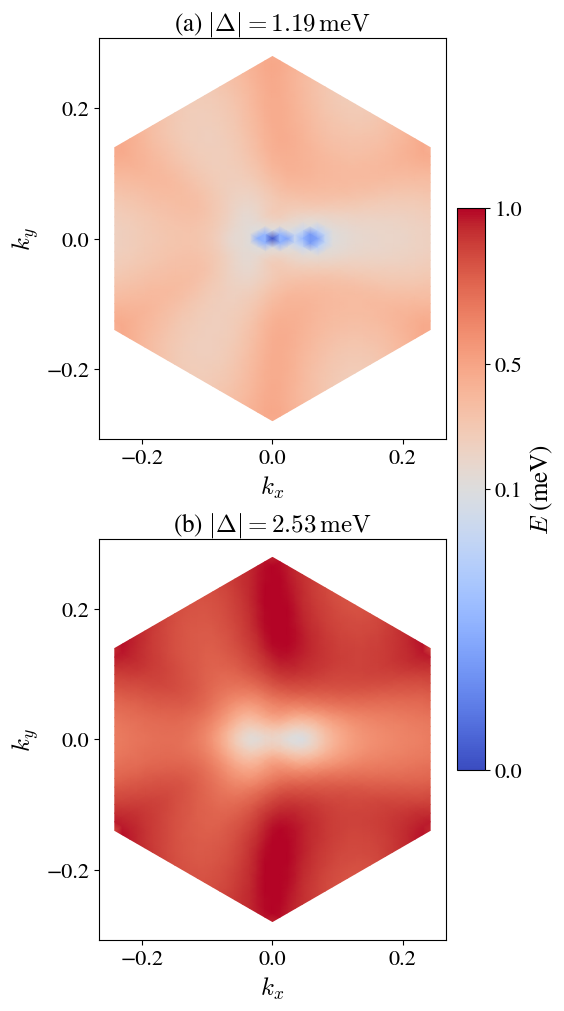

In [68]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, TwoSlopeNorm

# ---------- segmented colormap: 0–0.1 blue-ish; 0.1–1 yellow→red ----------
def _segmented_cmap_01():
    cdict = {
        "red":   [(0.00, 0.05, 0.05), (0.10, 0.30, 0.95), (1.00, 0.95, 0.95)],
        "green": [(0.00, 0.10, 0.10), (0.10, 0.85, 0.85), (1.00, 0.10, 0.10)],
        "blue":  [(0.00, 0.40, 0.40), (0.10, 0.20, 0.00), (1.00, 0.00, 0.00)],
    }
    return LinearSegmentedColormap("low_high_split_01", cdict)

# ---------- main plotter ----------
def plot_absE_norm_split_01_column(
    kxA, kyA, evalsA, ΔA,
    kxB, kyB, evalsB, ΔB,
    *, col=2, meV=True, percentile_ref=99,
    mode="segmented",                    # "segmented" (crisp) or "diverging" (smooth)
    save_png=False, outdir="plots_bdg_eigs", fname="absE_split_01_col.png",
    label_fs=16, tick_fs=14, yticks=(-0.2, 0.0, 0.2)
):
    """
    Plots |E| normalized to [0,1] for two cases in a 2x1 column layout, with a strong visual
    split at 0.1 and a shared colorbar (ticks: 0.1, 0.5, 0.9). Subtitles show (a/b) and |Δ| in meV.
    """
    triA = mtri.Triangulation(kxA, kyA)
    triB = mtri.Triangulation(kxB, kyB)

    # branch -> meV (if requested)
    scale = 1000.0 if meV else 1.0
    EA = scale * np.asarray(evalsA[:, col], float)
    EB = scale * np.asarray(evalsB[:, col], float)

    # shared robust reference for normalization
    A, B = EA,EB#np.abs(EA), np.abs(EB)
    E_ref = np.nanpercentile(np.r_[A, B], percentile_ref)
    if not np.isfinite(E_ref) or E_ref <= 0:
        raise ValueError("Failed to compute a valid E_ref for normalization.")
    NA = np.clip(A / E_ref, 0.0, 1.0)
    NB = np.clip(B / E_ref, 0.0, 1.0)

    # color model (range 0..1; ticks at 0.1, 0.5, 0.9)
    if mode == "segmented":
        cmap = _segmented_cmap_01()
        bounds = np.r_[np.linspace(0, 0.1, 6), np.linspace(0.15, 1.0, 18)]
        norm = BoundaryNorm(bounds, ncolors=256, clip=True)
    elif mode == "diverging":
        cmap = "coolwarm"
        norm = TwoSlopeNorm(vmin=0.0, vcenter=0.1, vmax=1.0)
    else:
        raise ValueError("mode must be 'segmented' or 'diverging'")

    # --- figure: 2 rows x 1 column ---
    fig, axes = plt.subplots(2, 1, figsize=(6.8, 10.0), constrained_layout=True)
    axA, axB = axes

    # Panel (a)
    imA = axA.tripcolor(triA, NA, shading="gouraud", cmap=cmap, norm=norm)
    axA.set_aspect("equal", adjustable="box")
    axA.set_xlabel(r"$k_x$", fontsize=label_fs)
    axA.set_ylabel(r"$k_y$", fontsize=label_fs)
    axA.set_yticks(list(yticks))
    axA.tick_params(axis="both", labelsize=tick_fs)
    axA.set_title(fr"(a) $|\Delta|={abs(ΔA)*1000:.2f}\,\mathrm{{meV}}$", fontsize=label_fs)

    # Panel (b)
    imB = axB.tripcolor(triB, NB, shading="gouraud", cmap=cmap, norm=norm)
    axB.set_aspect("equal", adjustable="box")
    axB.set_xlabel(r"$k_x$", fontsize=label_fs)
    axB.set_ylabel(r"$k_y$", fontsize=label_fs)
    axB.set_yticks(list(yticks))
    axB.tick_params(axis="both", labelsize=tick_fs)
    axB.set_title(fr"(b) $|\Delta|={abs(ΔB)*1000:.2f}\,\mathrm{{meV}}$", fontsize=label_fs)

    # shared colorbar on the right; fixed ticks
    cbar = fig.colorbar(imB, ax=axes, location="right", fraction=0.05, pad=0.02)
    cbar.set_label(r"$E$ (meV)" , fontsize=label_fs)
    cbar.set_ticks([0,0.1, 0.5, 1])
    cbar.ax.tick_params(labelsize=tick_fs)

    if save_png:
        os.makedirs(outdir, exist_ok=True)
        fig.savefig(os.path.join(outdir, fname), dpi=240, bbox_inches="tight")
    plt.show()

# ---------------- Example usage (uses your two cases) ----------------
# Assumes you already have: collect_bdg_eigs(flat_dir, DeltaLayer0, DeltaLayer1, mu=...)

flat_dir = "lambda_flat_singlet"

# Case A
Δ0A = +1.187420e-03 + 2.675820e-06j
muA = +1.122022e-03
DeltaLayer0A = (Δ0A, 0.0, 0.0)
DeltaLayer1A = (Δ0A, 0.0, 0.0)
kxA, kyA, _, evalsA = collect_bdg_eigs(flat_dir, DeltaLayer0A, DeltaLayer1A, mu=muA)

# Case B
Δ0B = +2.532643e-03 + 6.358490e-06j
muB = 9.369006e-04
DeltaLayer0B = (Δ0B, 0.0, 0.0)
DeltaLayer1B = (Δ0B, 0.0, 0.0)
kxB, kyB, _, evalsB = collect_bdg_eigs(flat_dir, DeltaLayer0B, DeltaLayer1B, mu=muB)

# Plot (normalized |E|, split at 0.1), no suptitle, no scatter/contours
plot_absE_norm_split_01_column(
    kxA, kyA, evalsA, Δ0A,
    kxB, kyB, evalsB, Δ0B,
    col=2, percentile_ref=99,
    mode="diverging",            # or "diverging" if you prefer smooth
    save_png=False,
    label_fs=18, tick_fs=16,     # larger fonts
    yticks=(-0.2, 0.0, 0.2)      # fixed y-ticks
)
